# Sports Networks: Limits of PageRank-based ranking methods in sports data
Click on `Run/Run All Cells` before starting (ensure that the collapsed cells are executed). 

In [2]:
import math, random, itertools

import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx

import matplotlib.pyplot as plt

from scipy.stats import rankdata
from scipy.stats.mstats import kendalltau
    
from random import choices, sample

from tqdm.notebook import trange, tqdm

In [3]:
#############################################################################################
# configuration expansion

def expand_configuration(config):
    experiments = []

    for n_teams in config["n_teams"]:

        for fitness_d in _expand_fitness(n_teams, config["fitness"]):

            for model_d in _expand_model(config["model"]):

                for fraction_games_per_season in config["fraction_games_per_season"]: 
                    
                    if config["fix_schedule_over_season"]:
                        schedule_graph = generate_synthetic_sports_schedule_graph(n_teams, fraction_games_per_season)
                    else:
                        schedule_graph = None
                        
                    for unexpected_result in  _expand_handle_unexpected_results(config["remove_unexpected"]):       
                        
                        for season in range(config["n_seasons"]): # repetition
                            d = {
                                "n_teams": n_teams,
                                **fitness_d,
                                **model_d,
                                "fraction_games_per_season": fraction_games_per_season,
                                "season": season,
                                "schedule_graph": schedule_graph,
                                "remove_unexpected_mode": unexpected_result["mode"],
                                "remove_unexpected_fraction_eta": unexpected_result["fraction_eta"]
                            }
                            experiments.append(d)

    return experiments


def _expand_handle_unexpected_results(unexpected_config):
    
    exps = []
    for unexpected in unexpected_config:
        for mode, fraction_eta in itertools.product(unexpected["mode"], unexpected["fraction_eta"]):
            d = {
                "mode": mode,
                "fraction_eta": fraction_eta
            }
            exps.append(d)
    return exps


def _expand_fitness(n_teams, fitness_config):
    
    fitness_exp = []
    
    for fitness in fitness_config:
        if fitness["type"] == "linear":
            d = {
                "fitness_type": "linear",
                "fitness_values": linear_fitness(N=n_teams) 
            }
            
        elif fitness["type"] == "nonlinear":
            fitness_values = []
            for alpha, beta, gamma in itertools.product(fitness["alpha"], fitness["beta"], fitness["gamma"]):
                fitness_values += []
                
                d = {
                    "fitness_type": "nonlinear",
                    "fitness_nonlinear_alpha": alpha,
                    "fitness_nonlinear_beta": beta,
                    "fitness_nonlinear_gamma": gamma,                    
                    "fitness_values": nonlinear_fitness(N=n_teams, alpha=alpha, beta=beta, gamma=gamma)
                }
        else:
            raise ValueError(f"unknown fitness: {fitness}")
        
        fitness_values_inv = [-fitness_value for fitness_value in d["fitness_values"]]
        gt_ranking = rankdata(fitness_values_inv, method='min')        
        gt_ranking = [{"team": team_id, "rank": rank, "score": score} for team_id, (rank, score) in enumerate(zip(gt_ranking, d["fitness_values"]))]
        gt_ranking = sorted(gt_ranking, key=lambda k: k["rank"])
        d["gt_ranking"] = gt_ranking
        
        fitness_exp.append(d)
    
    return fitness_exp


def _expand_model(model_config):
    
    model_exp = []
    
    for model in model_config:
        if model["type"] == "logistic":
            for H, delta in itertools.product(model["H"], model["delta"]):
                d = {
                    "model": "logistic",
                    "model_logistic_H": H,
                    "model_logistic_delta": delta
                }
                model_exp.append(d)
        else:
            raise ValueError(f"unknown model: {model}")
        
    return model_exp



#############################################################################################
# fitness levels

def linear_fitness(N):
    return [(i-0.5)/N  for i in range(1, N+1)]

def nonlinear_fitness(N, alpha, beta, gamma):
    
    gamma0 = 0 if gamma == "fix" else gamma 
    
    fitness_values = [beta * (((i-0.5)/N) ** alpha) + gamma0  for i in range(1, N+1)]
    
    if gamma == "fix": # choose gamma such that avg fitness level == 0.5
        gamma0 = 0.5 - sum(fitness_values) / N
        fitness_values = [x + gamma0 for x in fitness_values]
        
    return fitness_values

#############################################################################################
# models

def logistic_model(f_i, f_j, H, delta):
    # f_i fitness value of team i (home team)
    # f_j fitness value of team j (away team)
    # H: home advantage
    # delta: randomness factor
    return sigmoid((f_i - f_j + H)/delta)

# TODO: in the paper math formula, I think they have an additional ^-1 which is wrong
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

#############################################################################################
# simulate games

def generate_synthetic_sports_schedule_graph(n_teams, fraction_games_per_season):
    
    
    n_games = fraction_games_per_season * (n_teams - 1)
    
    n_games = int(n_games)
    
    total_n_games = fraction_games_per_season * n_teams * (n_teams-1) / 2
    
    sequence = [n_games] * n_teams
    
    n_teams_with_additional_game = 2 * int(total_n_games - n_games * n_teams / 2)
    
    teams_with_additional_game = sample(range(n_teams), n_teams_with_additional_game)
    for team in teams_with_additional_game:
        sequence[team] +=1
    
    assert(int(sum(sequence)/2) == int(total_n_games))
    
    # TODO with this approach you can only create a graph with fraction_of_games<=1    
    G = nx.random_degree_sequence_graph(sequence, seed=42, tries=1000)

        
    return G


def generate_synthetic_sports_results(exp, schedule_graph):
    # fraction of games can also be > 1 (league where teams play more than once against each other)    
    
    games = []
    for edge in schedule_graph.edges():
        # home team is chosen at random for each game
        home_team_idx = random.randint(0, 1)
        away_team_idx = (home_team_idx + 1) % 2 
        
        home_team = edge[home_team_idx]
        away_team = edge[away_team_idx]
        
        if exp["model"] == "logistic": 
            prob_home_team_win = logistic_model(f_i=exp["fitness_values"][home_team], f_j=exp["fitness_values"][away_team], H=exp["model_logistic_H"], delta=exp["model_logistic_delta"])
            home_team_win = bool(np.random.binomial(n=1, p=prob_home_team_win))
            
            result = "home" if home_team_win else "away"
        else:
            raise ValueError(f"Not Implemented Yet: model={model}")
        
        game = {
            "home": home_team,
            "away": away_team,
            "result": result
        }
        
        #print(f"edge={edge} game={game}")
        
        games.append(game)
        
    return games


def remove_unexpected_results(games, fitness_values, mode, fraction_eta):
    
    new_games = []
    unexpected_games = []
    
    for game in games:
        
        home_fitness = fitness_values[game["home"]]
        away_fitness = fitness_values[game["away"]]
        
        winner = game["result"]
        
        unexpected_result = (winner == "home" and home_fitness < away_fitness) or (winner == "away" and away_fitness < home_fitness)
        
        if unexpected_result:
            unexpected_games.append(game)
        else:
            new_games.append(game)
    
    
    n_games_to_update = int(fraction_eta * len(unexpected_games))
    
    random.shuffle(unexpected_games)
    
    for i, game in enumerate(unexpected_games):
        if i < n_games_to_update:
            if mode == "removal":
                #print(f"    update (remove): {game}")
                pass
            elif mode == "reversion":
                #print(f"    update (reversion): {game}")
                game["result"] = "home" if game["result"] == "away" else "away"
                new_games.append(game)
            else:
                raise ValueError(f"unknown remove unexpected mode: {mode}")
        else:
            new_games.append(game)
    
    info = f"updated={n_games_to_update} unexpected={len(unexpected_games)}({round(100*len(unexpected_games)/len(games))}%) total={len(games)}"
    return new_games, info

#############################################################################################
# game results to graph

def games_to_graph(n_teams, games, graph="winner"):
    
    G = nx.DiGraph(directed=True)
    G.add_nodes_from(range(0, n_teams))
    
    edges = []
    for game in games:
           
        if game["result"] == "home":
            winner = game["home"]
            loser = game["away"]
        elif game["result"] == "away":
            winner = game["away"]
            loser = game["home"]
        else:
            raise ValueError("Not Implemented Yet")
        
        if graph == "winner":
            # when team i wins against team j => a directed link from j to i "along which sports prestige flows"
            e = (loser, winner, 1)
        elif graph == "loser":
             # when team i wins against team j => a directed link from i to j
            e = (winner, loser, 1)
        else:
            raise ValueError(f"unknown graph type: {graph}")
        edges.append(e)
    
    # TODO at the moment each team can only against each other team once => don't need to combine edge weights
    
    G.add_weighted_edges_from(edges) # (start node, dest node, weight)
    
    return G

#############################################################################################
# ranking algos

def winratio(winner_graph):
    scores = {}
            
    for team in winner_graph.nodes():
        n_wins = winner_graph.in_degree(team)
        n_losses = winner_graph.out_degree(team)
        win_ratio = n_wins / (n_wins + n_losses)
        scores[team] =  win_ratio
    return scores
    

def bipagerank(winner_graph, loser_graph):
    scores_P = nx.pagerank(winner_graph)
    scores_Q = nx.pagerank(loser_graph)
            
    scores = {}
    for team, score_P in scores_P.items():
        score_Q = scores_Q[team]
        scores[team] = score_P - score_Q
    
    return scores


def scores_to_ranking(scores):
    
    # sort team by team index
    team_scores = [-score for team, score in sorted(scores.items(), key=lambda item: item[0])]
    
    # apply the ranking
    ranking = rankdata(team_scores, method='min')
    
    # convert ranking to dictionary (same form as scores)
    team_ranking = {team: {"rank": rank, "score": scores[team]} for team, rank in enumerate(ranking)}
    
    return team_ranking

#############################################################################################

# metrics
def topk_avg_rank(team_ranking, ranking_gt, k=5):
    
    top_k_teams = ranking_gt[:k]

    rank_sum = 0
    for x in top_k_teams:
        team_id = x["team"]
        rank_sum += team_ranking[team_id]["rank"]
    
    avg_rank_sum = rank_sum / k
    return avg_rank_sum

def kendall(team_ranking, ranking_gt):
    
    gt_ranking_lst = [x["rank"] for x in sorted(ranking_gt, key=lambda x: x["team"])]
    algo_ranking_lst = [team_ranking[team_id]["rank"] for team_id in sorted(team_ranking.keys())]
    
    
    tau_a, _ = kendalltau(algo_ranking_lst, gt_ranking_lst, use_ties=False, use_missing=False, method='auto')
    
    return tau_a


gt_ranking = [{'team': 4, 'rank': 1}, {'team': 3, 'rank': 2}, {'team': 2, 'rank': 3}, {'team': 1, 'rank': 4}, {'team': 0, 'rank': 5}]
team_ranking = {0: {'rank': 1}, 1: {'rank': 1}, 2: {'rank': 1}, 3: {'rank': 1}, 4: {'rank': 1}}
score = kendall(team_ranking, gt_ranking)
assert(score == 0)

team_ranking = {0: {'rank': 5}, 1: {'rank': 4}, 2: {'rank': 3}, 3: {'rank': 2}, 4: {'rank': 1}}
score = kendall(team_ranking, gt_ranking)
assert(score == 1)

team_ranking = {0: {'rank': 1}, 1: {'rank': 2}, 2: {'rank': 3}, 3: {'rank': 4}, 4: {'rank': 5}}
score = kendall(team_ranking, gt_ranking)
assert(score == -1)


def auc(team_ranking, ranking_gt, n, topk=5):
    
    goal_top_set = ranking_gt[:topk]
    ordinary_set = ranking_gt[topk:]
    
    # sample with replacement
    goal_top_set_samples = choices(goal_top_set,k=n)
    ordinary_set_samples = choices(ordinary_set,k=n)
    
    goal_higher_count = 0
    tied_count = 0
    for goal_team, ordinary_team in zip(goal_top_set_samples, ordinary_set_samples):
        
        goal_team_id = goal_team["team"]
        ordinary_team_id = ordinary_team["team"]
        
        goal_team_rank = team_ranking[goal_team_id]["rank"]
        ordinary_team_rank = team_ranking[ordinary_team_id]["rank"]
 
        if goal_team_rank < ordinary_team_rank:
            goal_higher_count += 1
        elif goal_team_rank == ordinary_team_rank:
            tied_count += 1

    
    auc = (goal_higher_count + tied_count/2) / n
    
    return auc

#############################################################################################


In [4]:
import time

def build_df(config):   
    experiments = expand_configuration(config)
    
    print(f"Config results in {len(experiments)} experiments")

    # simulate seasons
    for exp in tqdm(experiments):
        #print("========================================")
        #start_time = time.time()
        
        if "schedule_graph" not in exp or exp["schedule_graph"] is None:
            schedule_graph = generate_synthetic_sports_schedule_graph(n_teams=exp["n_teams"], fraction_games_per_season=exp["fraction_games_per_season"])
        else:
            schedule_graph = exp["schedule_graph"]
        
        exp["results"] = generate_synthetic_sports_results(exp, schedule_graph)
        
        exp["results"], exp["remove_unexpected_info"] = remove_unexpected_results(exp["results"], fitness_values=exp["fitness_values"], mode=exp["remove_unexpected_mode"], fraction_eta=exp["remove_unexpected_fraction_eta"])
        
        #print(f"generate synthetic: {time.time()-start_time} ")
        winner_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")
        
        #print(f"games to graph: {time.time()-start_time} ")

        # apply the ranking algorithms to the simulated seasons
        for ranking_algo in config["ranking_algos"]:
            if ranking_algo == "pagerank":
                scores = nx.pagerank(winner_graph)
                #print(f"pagerank: {time.time()-start_time} ")
            elif ranking_algo == "bipagerank":
                loser_graph = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="loser")
                scores = bipagerank(winner_graph, loser_graph)
                #print(f"bipagerank: {time.time()-start_time} ")
            elif ranking_algo == "winratio":
                scores = winratio(winner_graph)
                #print(f"winratio: {time.time()-start_time} ")
            else:
                raise ValueError(f"unknown ranking algo: {ranking_algo}")            
            
            team_ranking = scores_to_ranking(scores)
            
            # {<team_id>: {"rank": <rank>, "score": <score>}, ...}
            
            exp[f"{ranking_algo}_team_ranking"] = team_ranking
            
            # evaluate each ranking with the defined metrics
            for metric in config["metrics"]:
                if metric == "top5_avg_rank":
                    metric_score = topk_avg_rank(team_ranking, ranking_gt=exp["gt_ranking"], k=5)
                    #print(f"top5 avg rank: {time.time()-start_time}")

                elif metric == "kendall":
                    metric_score = kendall(team_ranking, ranking_gt=exp["gt_ranking"])
                    #print(f"kendall: {time.time()-start_time} ")

                elif metric == "auc":
                    metric_score = auc(team_ranking, ranking_gt=exp["gt_ranking"], n=100 , topk=5) # n is the number of sampled pairs
                    #print(f"auc: {time.time()-start_time} ")

                else:
                    raise ValueError(f"unknown metric: {metric}")

                exp[f"{ranking_algo}_{metric}"] = metric_score
   
    df = pd.DataFrame(experiments)
    
    # only keep the important columns 
    return df

def drop_additional_cols(df1):
    df1 = df1[df1.columns.drop(list(df1.filter(regex='_ranking')))]
    df1 = df1[df1.columns.drop(list(df1.filter(regex='_scores')))]
    df1 = df1.drop(columns=["fitness_values", "results", "schedule_graph"])
    return df1

## Example for Pipeline Config

In [175]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}, 
                {"type": "nonlinear", "alpha": [1], "beta":[0.4], "gamma": ["fix"] }],
    "model": [{"type": "logistic", "H": [0.1875], "delta": [0.25] }],
    "fraction_games_per_season":  [1], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False
}

df = build_df(config)
display(drop_additional_cols(df))

Config results in 100 experiments


  0%|          | 0/100 [00:00<?, ?it/s]

,n_teams,fitness_type,fitness_values,gt_ranking,model,model_logistic_H,model_logistic_delta,fraction_games_per_season,season,schedule_graph,...,bipagerank_top5_avg_rank,bipagerank_kendall,bipagerank_auc,winratio_team_ranking,winratio_top5_avg_rank,winratio_kendall,winratio_auc,fitness_nonlinear_alpha,fitness_nonlinear_beta,fitness_nonlinear_gamma
0,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...","[{'team': 29, 'rank': 1, 'score': 0.9833333333...",logistic,0.1875,0.25,1,0,None,...,3.6,0.843678,0.96,"{0: {'rank': 30, 'score': 0.0}, 1: {'rank': 27...",2.8,0.859770,0.965,NaN,NaN,NaN
1,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...","[{'team': 29, 'rank': 1, 'score': 0.9833333333...",logistic,0.1875,0.25,1,1,None,...,8.8,0.627586,0.80,"{0: {'rank': 29, 'score': 0.1724137931034483},...",7.0,0.673563,0.770,NaN,NaN,NaN
2,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...","[{'team': 29, 'rank': 1, 'score': 0.9833333333...",logistic,0.1875,0.25,1,2,None,...,4.0,0.779310,0.93,"{0: {'rank': 29, 'score': 0.1724137931034483},...",3.0,0.760920,0.970,NaN,NaN,NaN
3,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...","[{'team': 29, 'rank': 1, 'score': 0.9833333333...",logistic,0.1875,0.25,1,3,None,...,5.0,0.765517,0.92,"{0: {'rank': 26, 'score': 0.27586206896551724}...",3.8,0.781609,0.975,NaN,NaN,NaN
4,30,linear,"[0.016666666666666666, 0.05, 0.083333333333333...","[{'team': 29, 'rank': 1, 'score': 0.9833333333...",logistic,0.1875,0.25,1,4,None,...,4.4,0.724138,0.97,"{0: {'rank': 29, 'score': 0.13793103448275862}...",3.4,0.802299,0.965,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,nonlinear,"[0.3066666666666666, 0.31999999999999995, 0.33...","[{'team': 29, 'rank': 1, 'score': 0.6933333333...",logistic,0.1875,0.25,1,45,None,...,4.4,0.632184,0.94,"{0: {'rank': 28, 'score': 0.3448275862068966},...",3.8,0.620690,0.955,1.0,0.4,fix
96,30,nonlinear,"[0.3066666666666666, 0.31999999999999995, 0.33...","[{'team': 29, 'rank': 1, 'score': 0.6933333333...",logistic,0.1875,0.25,1,46,None,...,10.0,0.577011,0.75,"{0: {'rank': 23, 'score': 0.3793103448275862},...",8.4,0.574713,0.705,1.0,0.4,fix
97,30,nonlinear,"[0.3066666666666666, 0.31999999999999995, 0.33...","[{'team': 29, 'rank': 1, 'score': 0.6933333333...",logistic,0.1875,0.25,1,47,None,...,5.2,0.577011,0.88,"{0: {'rank': 28, 'score': 0.27586206896551724}...",3.8,0.581609,0.925,1.0,0.4,fix
98,30,nonlinear,"[0.3066666666666666, 0.31999999999999995, 0.33...","[{'team': 29, 'rank': 1, 'score': 0.6933333333...",logistic,0.1875,0.25,1,48,None,...,6.4,0.590805,0.86,"{0: {'rank': 26, 'score': 0.3448275862068966},...",5.6,0.581609,0.880,1.0,0.4,fix


In [6]:
%time
# (~ 16 min) 

# configure here the experiments (the pipeline will create a cross product for every element in a list)
# config = {
#     "n_teams": [30],
#     "fitness": [{"type": "linear"}],
#     "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 5), "delta": np.linspace(0.01,0.35, 5) }],
#     "fraction_games_per_season":  [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
#     "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
#     "n_seasons": 100, # number of repetitions
#     "ranking_algos": ["pagerank", "bipagerank", "winratio"],
#     "metrics": ["kendall", "auc", "top5_avg_rank"]
# }

# df = build_df(config)

# display(drop_additional_cols(df))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


# Real data


In [67]:
import os
import re

directory = "data"
pattern = "^(\\d{4})-(\\d{4}) ([a-zA-Z ]*) \\(([A-Z])\\).csv$"

real_data_games = pd.DataFrame()

for filename in os.listdir(directory):
    match = re.search(pattern, filename)
    if not match:
        continue

    start_year = int(match.group(1))
    end_year = int(match.group(2))
    league_name = match.group(3)

    content = pd.read_csv(os.path.join(directory, filename), delimiter=";").dropna(how='all')
    content["start_year"] = start_year
    content["end_year"] = end_year
    content["league_name"] = league_name
    real_data_games = real_data_games.append(content)
    print(f"Loaded {league_name} ({start_year}-{end_year})")


Loaded Premier League (2010-2011)
Loaded Premier League (2015-2016)
Loaded Bundesliga (2017-2018)
Loaded Bundesliga (2011-2012)
Loaded Bundesliga (2014-2015)
Loaded Bundesliga (2016-2017)
Loaded Premier League (2020-2021)
Loaded Bundesliga (2020-2021)
Loaded Premier League (2011-2012)
Loaded Premier League (2016-2017)
Loaded Premier League (2017-2018)
Loaded Premier League (2013-2014)
Loaded Bundesliga (2010-2011)
Loaded Premier League (2019-2020)
Loaded Bundesliga (2015-2016)
Loaded Bundesliga (2018-2019)
Loaded Premier League (2018-2019)
Loaded Bundesliga (2019-2020)
Loaded Bundesliga (2012-2013)
Loaded Premier League (2012-2013)
Loaded Bundesliga (2013-2014)


In [173]:
real_data_teams = pd.DataFrame()

for _, (start_year, end_year, league) in real_data_games[["start_year", "end_year", "league_name"]]\
                                        .drop_duplicates().iterrows():
    season = real_data_games[(real_data_games["start_year"] == start_year) &\
                             (real_data_games["end_year"] == end_year) &\
                             (real_data_games["league_name"] == league)]
    
    teams_home = season["Home"].unique()
    teams_away = season["Away"].unique()
    diff = np.setdiff1d(teams_home, teams_away)
    assert diff.shape[0] == 0, "Teams Home and Away must be the same!"
    
    n_teams = teams_home.shape[0]
    

    v = season["Score"].str.split("–", expand=True)
#     games = season[v[0] != v[1]] # Filter draws
    games_home_won = season[v[0] > v[1]]
    games_away_won = season[v[0] < v[1]]
    
    
    teams_playcount = {
        team: len(season[(((season["Home"] == team) | (season["Away"] == team)) & (v[0] != v[1]))].index) for team in teams_home
    }
    
    winning_teams = season[v[0] > v[1]]["Home"].append(season[v[0] < v[1]]["Away"]).sort_index()
#     print(f"Removed {len(season.index) - len(winning_teams.index)} draws ({(len(season.index) - len(winning_teams.index)) / len(season.index)}%)")

    
    teams_wincount = {
        team: len(winning_teams[winning_teams == team].index) for team in teams_home
    }
    teams_winratio = {
        team: wins / teams_playcount[team] for team, wins in teams_wincount.items()
    }
    teams_sorted = list(teams_winratio.items())
    teams_sorted.sort(key=lambda x: x[1], reverse=False)
    
    df = pd.DataFrame({
        'rank': range(1, n_teams + 1),
        'team': [x[0] for x in teams_sorted],
        'win_ratio': [x[1] for x in teams_sorted],
        'league': league,
        'start_year': start_year,
        'end_year': end_year
    })
    real_data_teams = real_data_teams.append(df)
    
#     print(df)
#     print(f"Average winratio: {df['win_ratio'].sum() / n_teams}")
display(real_data_teams)

    rank             team  win_ratio          league  start_year  end_year
0      1         West Ham   0.269231  Premier League        2010      2011
1      2        Blackpool   0.344828  Premier League        2010      2011
2      3  Birmingham City   0.347826  Premier League        2010      2011
3      4           Wolves   0.354839  Premier League        2010      2011
4      5   Wigan Athletic   0.391304  Premier League        2010      2011
..   ...              ...        ...             ...         ...       ...
13    14       Leverkusen   0.633333      Bundesliga        2013      2014
14    15        Wolfsburg   0.642857      Bundesliga        2013      2014
15    16       Schalke 04   0.703704      Bundesliga        2013      2014
16    17         Dortmund   0.758621      Bundesliga        2013      2014
17    18    Bayern Munich   0.935484      Bundesliga        2013      2014

[398 rows x 6 columns]


# Fitting

# Plotting

Average winratio input: 0.4904166666666667
Average winratio: 0.4904248596726693
0.4904248596726693
alpha=0.0002927994920718632, beta=223.35438828525795, gamma=-222.80045179096362


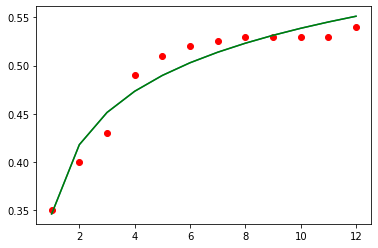

In [179]:
from scipy.optimize import least_squares

def nonlinear_fitness_model(theta, i, N):
    """
    N is fixed
    gamma is set after tweaking alpha and beta to normalize.
    """
    alpha, beta, gamma = theta[0], theta[1], theta[2]
    # print(alpha, beta)
    return beta * np.power((i - 0.5) / N, alpha) + gamma
    # return theta[0] / (1 + np.exp(- theta[1] * (t - theta[2])))
    
    
def determine_gamma(alpha, beta, N):
    """
    In case choose alfa and beta, we should be normalize the winratios so that the average is always 0.5 (someones win
    is always someone elses loss).
    This should be implicit in the natural data that we get.
    :return: gamma
    """
    average = np.sum([nonlinear_fitness_model([alpha, beta], i, N) for i in range(1, N+1)]) / N
    return 0.5 - average


def fit_nonlinear_model(df, visualize=False):

    # Prepare datapoints
    N = df['rank'].count()
    X = df['rank'].values
    Y = df['win_ratio'].values
    def fun(theta):
        return nonlinear_fitness_model(theta, X, N) - Y

    theta0 = [0.5,2, 0]
    result = least_squares(fun, theta0)
    result_theta = result.x

    if visualize:
        plt.scatter(X, Y, color="red")
        plt.plot(X, [nonlinear_fitness_model(result_theta, t, N) for t in X])
        print(f"Average winratio input: {np.sum(Y) / N}")
        print(f"Average winratio: {np.sum([nonlinear_fitness_model(result_theta, t, N) for t in X]) / N}")

    if visualize:
        print(np.sum([nonlinear_fitness_model(result_theta, t, N) for t in X]) / N)
        plt.plot(X, [nonlinear_fitness_model(result_theta, t, N) for t in X], color='green')

        print(f"alpha={result_theta[0]}, beta={result_theta[1]}, gamma={result_theta[2]}")

    return result_theta[0], result_theta[1], result_theta[2]

_, _, _ = fit_nonlinear_model(real_league_winratio, visualize=True)


In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns


In [10]:

# General plotting config

COLOR_GRAY = '#666666'

plot_config = {
    'colors': {
        0.1: 'red',
        0.3: 'green',
        0.8: 'blue',

        # Smaller data
        0.5: 'red',
        1.0: 'green',
        
        # algos
        "winratio": 'green',
        "pagerank": 'red',
        "bipagerank": 'blue'
    },
    'linestyles': {
        "pagerank": "dashed",
        "bipagerank": "dotted",
        "winratio": "solid"
    },
    'algo_names': {
        "pagerank": "PageRank",
        "bipagerank": "BiPageRank",
        "winratio": "WinRatio"
    },
    'ylabels': {
        "top5_avg_rank": "average ranking of top 5",
        "kendall": "Kendall $\\tau$",
        "auc": "AUC of top 5"
    },
    "update_removal_mode_names":{
        "removal": "upset removal",
        "reversion": "upset reversion"
    }
}

In [199]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": [0], "delta": np.linspace(0.01, 0.4, 4) }],
    "fraction_games_per_season": np.concatenate([np.linspace(0.04, 1.0, 4), [0.1, 0.3, 0.8]]), # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False
}

df = build_df(config)
display(drop_additional_cols(df))

Config results in 1400 experiments


  0%|          | 0/1400 [00:00<?, ?it/s]

,n_teams,fitness_type,model,model_logistic_H,model_logistic_delta,fraction_games_per_season,season,remove_unexpected_mode,remove_unexpected_fraction_eta,remove_unexpected_info,pagerank_top5_avg_rank,pagerank_kendall,pagerank_auc,bipagerank_top5_avg_rank,bipagerank_kendall,bipagerank_auc,winratio_top5_avg_rank,winratio_kendall,winratio_auc
0,30,linear,logistic,0,0.01,0.04,0,removal,0.0,updated=0 unexpected=0(0%) total=17,3.8,0.411494,0.805,3.8,0.411494,0.815,1.0,0.475862,0.840
1,30,linear,logistic,0,0.01,0.04,1,removal,0.0,updated=0 unexpected=0(0%) total=17,4.0,0.393103,0.830,4.0,0.337931,0.850,1.0,0.370115,0.820
2,30,linear,logistic,0,0.01,0.04,2,removal,0.0,updated=0 unexpected=0(0%) total=17,3.0,0.427586,0.880,3.0,0.432184,0.895,1.0,0.402299,0.835
3,30,linear,logistic,0,0.01,0.04,3,removal,0.0,updated=0 unexpected=0(0%) total=17,3.4,0.397701,0.840,3.4,0.452874,0.875,1.0,0.397701,0.815
4,30,linear,logistic,0,0.01,0.04,4,removal,0.0,updated=0 unexpected=0(0%) total=17,3.4,0.397701,0.850,3.4,0.427586,0.865,1.0,0.370115,0.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,30,linear,logistic,0,0.40,0.80,45,removal,0.0,updated=0 unexpected=96(28%) total=348,3.6,0.696552,0.980,3.2,0.811494,0.980,3.2,0.751724,0.980
1396,30,linear,logistic,0,0.40,0.80,46,removal,0.0,updated=0 unexpected=112(32%) total=348,5.8,0.586207,0.860,4.2,0.668966,0.950,3.2,0.664368,0.990
1397,30,linear,logistic,0,0.40,0.80,47,removal,0.0,updated=0 unexpected=99(28%) total=348,8.2,0.508046,0.780,5.8,0.627586,0.870,3.8,0.671264,0.980
1398,30,linear,logistic,0,0.40,0.80,48,removal,0.0,updated=0 unexpected=112(32%) total=348,7.0,0.613793,0.830,7.2,0.673563,0.820,6.4,0.721839,0.850


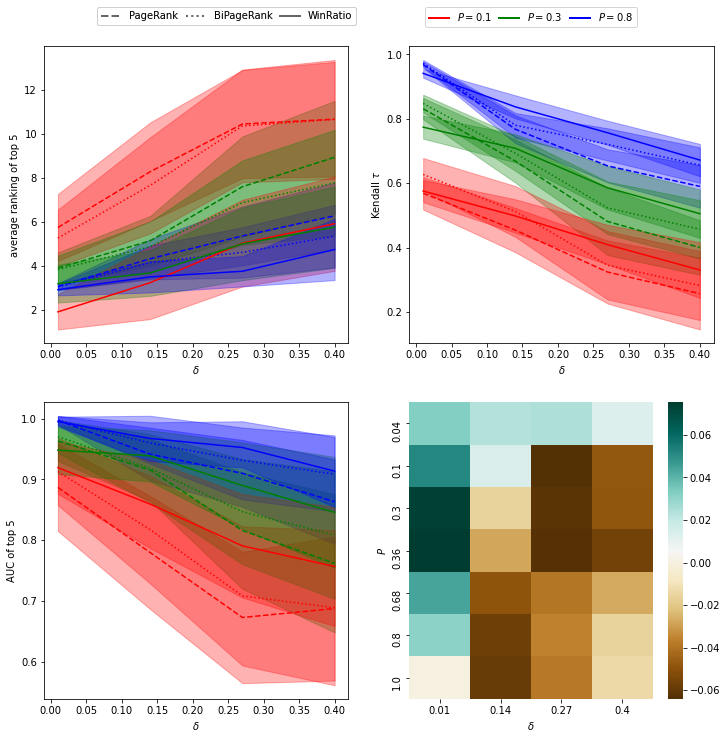

In [201]:

plot_fractions = [0.1, 0.3, 0.8]

def build_figure_3():
    plots_v = 2
    plots_h = 2
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 12])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    #######################
    # First three figures #
    #######################
    for index, metric in enumerate(config['metrics']):
        for algo in config['ranking_algos']:
            for fraction in plot_fractions:
                rows = df[df[f"fraction_games_per_season"] == fraction]
                groups = rows.groupby("model_logistic_delta")
                labels = groups.groups.keys()

                suffix = f"{algo}_{metric}"
                values = groups.mean()[suffix]
                stderr = groups.std()[suffix]
                ax = axes[int(index / plots_h), index % plots_h]
                ax.plot(labels, values,
                                color=plot_config['colors'][fraction],
                                linestyle=plot_config['linestyles'][algo]
                                )
                ax.fill_between(labels, values - stderr, values + stderr,
                                        color=plot_config['colors'][fraction],
                                        alpha=0.3)

                ax.set_ylabel(plot_config['ylabels'][metric])
                ax.set_xlabel("$\delta$")

    #######################
    # Heatmap #
    #######################

    plot_data = df
    plot_data["difference"] = plot_data["bipagerank_kendall"] - plot_data["winratio_kendall"]
    plot_data = plot_data[["model_logistic_delta", "fraction_games_per_season", "difference"]]
    grouped = plot_data.groupby(["model_logistic_delta", "fraction_games_per_season"]).mean()
    grouped = grouped["difference"].unstack(0)

    ax = sns.heatmap(grouped, cmap="BrBG", ax=axes[1, 1])
#                      yticklabels=[0.04, 0.2, 0.4, 0.6, 0.8, 1.0], xticklabels=[0.01, 0.08, 0.16, 0.24, 0.4])
    ax.set_ylabel("$P$")
#     ax.set_yticks([0.04, 0.2, 0.4, 0.6, 0.8, 1.0])

    ax.set_xlabel("$\\delta$")
#     ax.set_xticks([0.01, 0.08, 0.16, 0.24, 0.4])

    ##########
    # LEGEND #
    ##########

    legend_algo = [Line2D([0], [0], linestyle=style, lw=2, color=COLOR_GRAY) for style in plot_config['linestyles'].values()]
    legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=color) for color in plot_config['colors'].values()]

    leg1 = plt.legend(legend_fraction, [f"$P = {fraction}$" for fraction in plot_fractions],
                      bbox_to_anchor=(0.5, 2.35), loc='upper center',
                      ncol=len(plot_config['colors'].keys()), columnspacing=0.75)
    leg2 = plt.legend(legend_algo, [plot_config['algo_names'][key] for key in plot_config['linestyles'].keys()],
                      bbox_to_anchor=(-0.75, 2.35), loc='upper center',
                      ncol=len(plot_config['linestyles'].keys()), columnspacing=0.75)
    fig.add_artist(leg1)
    fig.add_artist(leg2)
    plt.show()

build_figure_3()


In [203]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config = {
    "n_teams": [30],
    "fitness": [{"type": "linear"}],
    "model": [{"type": "logistic", "H": np.linspace(0.0, 0.3, 10), "delta": [0.1]}],
    "fraction_games_per_season": [0.1, 0.3, 0.8], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal"], "fraction_eta": [0.0]}],
    "n_seasons": 50, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["top5_avg_rank", "kendall", "auc"],
    "fix_schedule_over_season": False
}

df = build_df(config)
display(drop_additional_cols(df))

Config results in 1500 experiments


  0%|          | 0/1500 [00:00<?, ?it/s]

,n_teams,fitness_type,model,model_logistic_H,model_logistic_delta,fraction_games_per_season,season,remove_unexpected_mode,remove_unexpected_fraction_eta,remove_unexpected_info,pagerank_top5_avg_rank,pagerank_kendall,pagerank_auc,bipagerank_top5_avg_rank,bipagerank_kendall,bipagerank_auc,winratio_top5_avg_rank,winratio_kendall,winratio_auc
0,30,linear,logistic,0.0,0.1,0.1,0,removal,0.0,updated=0 unexpected=2(5%) total=43,5.4,0.588506,0.91,5.0,0.632184,0.950,1.0,0.583908,0.945
1,30,linear,logistic,0.0,0.1,0.1,1,removal,0.0,updated=0 unexpected=4(9%) total=43,7.4,0.528736,0.85,8.0,0.563218,0.800,2.4,0.544828,0.915
2,30,linear,logistic,0.0,0.1,0.1,2,removal,0.0,updated=0 unexpected=5(12%) total=43,6.4,0.457471,0.87,4.8,0.655172,0.930,2.6,0.544828,0.900
3,30,linear,logistic,0.0,0.1,0.1,3,removal,0.0,updated=0 unexpected=3(7%) total=43,6.8,0.549425,0.92,6.2,0.609195,0.790,2.2,0.565517,0.910
4,30,linear,logistic,0.0,0.1,0.1,4,removal,0.0,updated=0 unexpected=6(14%) total=43,12.0,0.381609,0.62,10.4,0.416092,0.715,4.0,0.505747,0.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,30,linear,logistic,0.3,0.1,0.8,45,removal,0.0,updated=0 unexpected=78(22%) total=348,4.8,0.737931,0.91,5.0,0.737931,0.880,3.6,0.781609,0.940
1496,30,linear,logistic,0.3,0.1,0.8,46,removal,0.0,updated=0 unexpected=89(26%) total=348,3.6,0.806897,0.97,3.4,0.806897,0.990,4.0,0.779310,0.920
1497,30,linear,logistic,0.3,0.1,0.8,47,removal,0.0,updated=0 unexpected=76(22%) total=348,3.8,0.696552,0.96,3.6,0.696552,0.960,3.2,0.735632,0.970
1498,30,linear,logistic,0.3,0.1,0.8,48,removal,0.0,updated=0 unexpected=84(24%) total=348,4.6,0.687356,0.95,3.8,0.724138,0.960,3.6,0.758621,0.945


    rank             team  win_ratio          league  start_year  end_year
0      1         West Ham   0.269231  Premier League        2010      2011
1      2        Blackpool   0.344828  Premier League        2010      2011
2      3  Birmingham City   0.347826  Premier League        2010      2011
3      4           Wolves   0.354839  Premier League        2010      2011
4      5   Wigan Athletic   0.391304  Premier League        2010      2011
..   ...              ...        ...             ...         ...       ...
13    14       Leverkusen   0.633333      Bundesliga        2013      2014
14    15        Wolfsburg   0.642857      Bundesliga        2013      2014
15    16       Schalke 04   0.703704      Bundesliga        2013      2014
16    17         Dortmund   0.758621      Bundesliga        2013      2014
17    18    Bayern Munich   0.935484      Bundesliga        2013      2014

[398 rows x 6 columns]


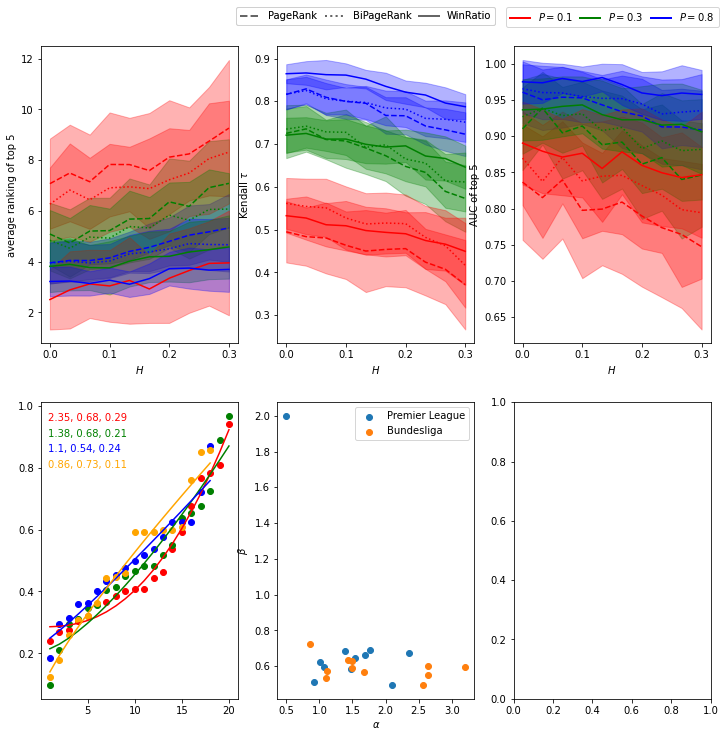

In [227]:

leagues_to_fit = [
    {'league': 'Premier League', 'start_year': 2017, 'color': 'red'},
    {'league': 'Premier League', 'start_year': 2018, 'color': 'green'},
#     {'league': 'Premier League', 'start_year': 2019, 'color': 'blue'},
#     {'league': 'Premier League', 'start_year': 2020, 'color': 'orange'}


    {'league': 'Bundesliga', 'start_year': 2017, 'color': 'blue'},
    {'league': 'Bundesliga', 'start_year': 2018, 'color': 'orange'}


]
plot_fractions = [0.1, 0.3, 0.8]


def build_figure_4():
    plots_v = 2
    plots_h = 3
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 12])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    #######################
    # First three figures #
    #######################
    for index, metric in enumerate(config['metrics']):
        for algo in config['ranking_algos']:
            for fraction in config['fraction_games_per_season']:
                rows = df[df[f"fraction_games_per_season"] == fraction]
                groups = rows.groupby("model_logistic_H")
                labels = groups.groups.keys()

                suffix = f"{algo}_{metric}"
                values = groups.mean()[suffix]
                stderr = groups.std()[suffix]
                ax = axes[int(index / plots_h), index % plots_h]
                ax.plot(labels, values,
                                color=plot_config['colors'][fraction],
                                linestyle=plot_config['linestyles'][algo]
                                )
                ax.fill_between(labels, values - stderr, values + stderr,
                                        color=plot_config['colors'][fraction],
                                        alpha=0.3)

                ax.set_ylabel(plot_config['ylabels'][metric])
                ax.set_xlabel("$H$")

    ##########################
    # Fitting fitness values #
    ##########################
    ax = axes[1, 0]
    for i, league in enumerate(leagues_to_fit):
        row = real_data_teams[(real_data_teams['league'] == league['league']) &\
                              (real_data_teams['start_year'] == league['start_year'])]
        N = row['rank'].count()
        color = league['color']
        ax.scatter(row['rank'], row['win_ratio'], color=color)

        alpha, beta, gamma = fit_nonlinear_model(row)
        ax.text(0.8, 0.95 - (i * 0.05), f"{round(alpha, 2)}, {round(beta, 2)}, {round(gamma, 2)}", color=color)
        ax.plot(row['rank'], [nonlinear_fitness_model([alpha, beta, gamma], i, N) for i in range(1, N+1)], color=color)

    ##########################
    # Plotting alfa, beta #
    ##########################
#     print(list(real_data_teams.iteritems()))
#     print(list(real_data_teams.iteritems())[0])
    print(real_data_teams)
    ax = axes[1, 1]
    for _, (league) in real_data_teams["league"].drop_duplicates().iteritems():
        fits = []

        for _, (start_year, end_year) in real_data_teams[["start_year", "end_year"]]\
                                                .drop_duplicates().iterrows():
            season = real_data_teams[(real_data_teams["start_year"] == start_year) &\
                                     (real_data_teams["end_year"] == end_year) &\
                                     (real_data_teams["league"] == league)]
            alpha, beta, gamma = fit_nonlinear_model(season)
            fits.append((alpha, beta))
        
        ax.scatter([f[0] for f in fits], [f[1] for f in fits], label=f"{league}")
    ax.set_xlabel("$\\alpha$")
    ax.set_ylabel("$\\beta$")
    ax.legend()


    #######################
    # Heatmap #
    #######################
    # TODO Based on real data
    # plot_data = df
    # plot_data["difference"] = plot_data["bipagerank_kendall"] - plot_data["winratio_kendall"]
    # plot_data = plot_data[["model_logistic_delta", "fraction_games_per_season", "difference"]]
    # grouped = plot_data.groupby(["model_logistic_delta", "fraction_games_per_season"]).mean()
    # grouped = grouped["difference"].unstack(0)
    #
    # ax = sns.heatmap(grouped, cmap="BrBG", ax=axes[1, 1])
    # ax.set_ylabel("$P$")
    # ax.set_xlabel("$H$")
    # ax.set_xticks([0.01, 0.08, 0.16, 0.24, 0.4])

    ##########
    # LEGEND #
    ##########

    legend_algo = [Line2D([0], [0], linestyle=style, lw=2, color=COLOR_GRAY) for style in plot_config['linestyles'].values()]
    legend_fraction = [Line2D([0], [0], linestyle='solid', lw=2, color=color) for color in plot_config['colors'].values()]

    leg1 = plt.legend(legend_fraction, [f"$P = {fraction}$" for fraction in plot_fractions],
                      bbox_to_anchor=(0.5, 2.35), loc='upper center',
                      ncol=len(plot_config['colors'].keys()), columnspacing=0.75)
    leg2 = plt.legend(legend_algo, [plot_config['algo_names'][key] for key in plot_config['linestyles'].keys()],
                      bbox_to_anchor=(-0.75, 2.35), loc='upper center',
                      ncol=len(plot_config['linestyles'].keys()), columnspacing=0.75)
    fig.add_artist(leg1)
    fig.add_artist(leg2)
    plt.show()

build_figure_4()


### Figure 5

In [228]:
# configure here the experiments (the pipeline will create a cross product for every element in a list)
config_fig5 = {
    "n_teams": [30],
    "fitness": [{"type": "nonlinear", "alpha": [1.5], "beta":[0.5], "gamma": ["fix"] }],
    "model": [{"type": "logistic", "H": [0.08], "delta": [0.25] }],
    "fraction_games_per_season":  [1], # P in paper (can only be between [0,1])
    "remove_unexpected": [{"mode": ["removal", "reversion"], "fraction_eta": np.linspace(0, 1, 50)}], 
    "n_seasons": 100, # number of repetitions
    "ranking_algos": ["pagerank", "bipagerank", "winratio"],
    "metrics": ["kendall"],
    "fix_schedule_over_season": True
}

df_fig5 = build_df(config_fig5)
display(drop_additional_cols(df_fig5))

Config results in 10000 experiments


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def build_figure_5(df, config):
    plots_v = 1
    plots_h = 2
    fig, axes = plt.subplots(plots_v, plots_h, figsize=[12, 4])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    
    metric = "kendall"
    for index, remove_unexpected_mode in enumerate(df['remove_unexpected_mode'].unique()):
        for algo in config['ranking_algos']:
            rows = df[df["remove_unexpected_mode"]==remove_unexpected_mode]
            groups = rows.groupby("remove_unexpected_fraction_eta")
            labels = groups.groups.keys()

            suffix = f"{algo}_{metric}"
            values = groups.mean()[suffix]
            stderr = groups.std()[suffix]
            ax = axes[index]
            ax.plot(labels, values,
                            label=plot_config["algo_names"][algo],
                            color=plot_config['colors'][algo])
            ax.fill_between(labels, values - stderr, values + stderr,
                                    color=plot_config['colors'][algo],
                                    alpha=0.3)

            ax.set_ylabel(plot_config['ylabels'][metric])
            ax.set_xlabel("$\\eta$")
            ax.set_title(plot_config["update_removal_mode_names"][remove_unexpected_mode])
            ax.legend()
    plt.show()

build_figure_5(df_fig5, config_fig5)

## Visualize a Graph

In [ ]:
# Show winner graph of 1st experiment
exp = df.iloc[0]
        
G = games_to_graph(n_teams=exp["n_teams"], games=exp["results"], graph="winner")

pos=nx.spring_layout(G)
nx.draw(G, pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos, edge_labels=labels)
labels= {i: node for i, node in enumerate(range(exp["n_teams"]))}
nx.draw_networkx_labels(G,pos,labels=labels,font_size=16)